In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [5]:
engine.execute('SELECT * FROM measurement').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#check what columns are available
columns_measurement = inspector.get_columns('measurement')
print('Measurement:')
for c in columns_measurement:
    print(c['name'], c["type"])

print('_______________________')
print("")
columns_station = inspector.get_columns('station')
print('Station:')
for c in columns_station:
    print(c['name'], c["type"])

Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
_______________________

Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_dt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_dt


('2017-08-23')

2016-08-24


<Figure size 432x288 with 0 Axes>

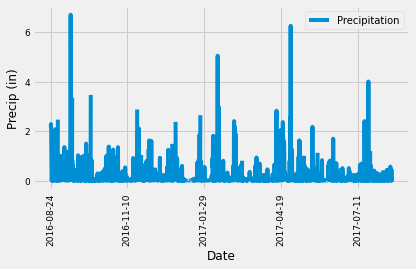

In [12]:
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all()

print(results[0][0])
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_rows = [{"Date": result[0], "Precipitation": result[1]} for result in results]
prcp_df = pd.DataFrame(prcp_rows).set_index("Date")

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
prcp_df.plot(legend=True, fontsize=9)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Precip (in)', fontsize=12)
plt.xticks(rotation=90)
plt.legend(loc='best', bbox_to_anchor=(.71,1), fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
sel = [func.count(Station.station)]
station_count = session.query(*sel).all()
print(f'Total Number of Stations in Dataset: {station_count[0][0]}')

Total Number of Stations in Dataset: 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_counts[0][0]
most_active_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).all()
temp_df = pd.DataFrame(most_active_temp)

print(f"The mean temp at station {most_active} = {round(temp_df['tobs'].mean(),2)}")
print('')
print(f"The max temp at station {most_active} = {round(temp_df['tobs'].max(),2)}")
print("")
print(f"The min temp at station {most_active} = {round(temp_df['tobs'].min(),2)}")

The mean temp at station USC00519281 = 71.66

The max temp at station USC00519281 = 85.0

The min temp at station USC00519281 = 54.0


('2017-08-18',)


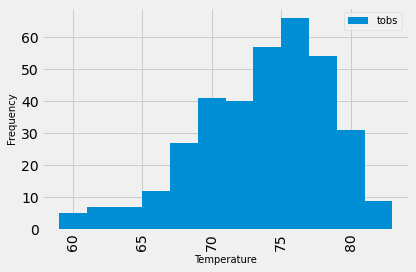

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_enddate = session.query(Measurement.date).order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active).first()
print(most_active_enddate)
last_year = dt.datetime(2017,8,18) - dt.timedelta(days=365)
temp_prv_mths = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > last_year).all()
temp_lstyr_df = pd.DataFrame(temp_prv_mths)

temp_lstyr_df.plot.hist(bins=12)
plt.xlabel('Temperature', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(rotation=90)
plt.legend(loc='best', bbox_to_anchor=(.81,1), fontsize=10)
plt.tight_layout()

plt.show()

# Close session

In [19]:
# Close Session
session.close()